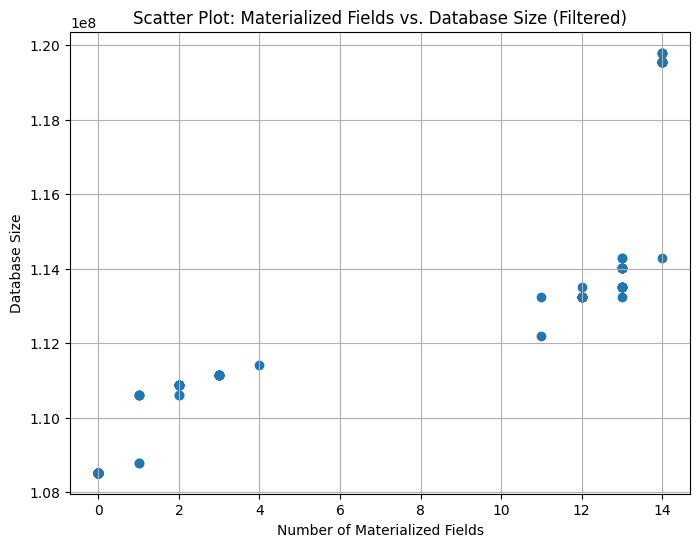

In [52]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

RESULTS_PATH = "../results/tpch/2025-03-05-15H"

# Read the CSV file
meta_results = pd.read_csv(RESULTS_PATH + "/meta_results.csv")

# Exclude rows where Test is full_materialization

# Function to count the number of materialized fields from the string representation
def count_materialized_fields(s):
    try:
        # If the string represents dict_keys, remove the wrapper to get the list
        if s.startswith("dict_keys"):
            s_list = s[len("dict_keys("):-1]
            fields = ast.literal_eval(s_list)
        else:
            fields = ast.literal_eval(s)
        return len(fields)
    except Exception as e:
        # Fallback: remove brackets and count commas
        s_clean = s.strip("[]")
        if not s_clean:
            return 0
        return s_clean.count(",") + 1

# Create a new column with the number of materialized fields
meta_results["num_materialized_fields"] = meta_results["Materialization"].apply(count_materialized_fields)

meta_results_no_full = meta_results[meta_results["Test"] != "full_materialization"]


# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(meta_results_no_full["num_materialized_fields"], meta_results_no_full["Database size"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Database Size")
plt.title("Scatter Plot: Materialized Fields vs. Database Size (Filtered)")
plt.grid(True)
plt.show()


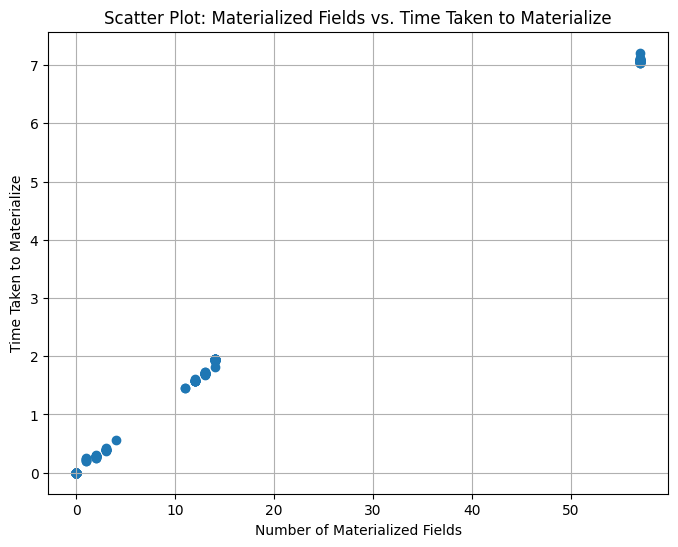

In [53]:
# Create the scatter plot: x-axis = number of materialized fields, y-axis = time taken to materialize
plt.figure(figsize=(8, 6))
plt.scatter(meta_results["num_materialized_fields"], meta_results["Time taken"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Time Taken to Materialize")
plt.title("Scatter Plot: Materialized Fields vs. Time Taken to Materialize")
plt.grid(True)
plt.show()

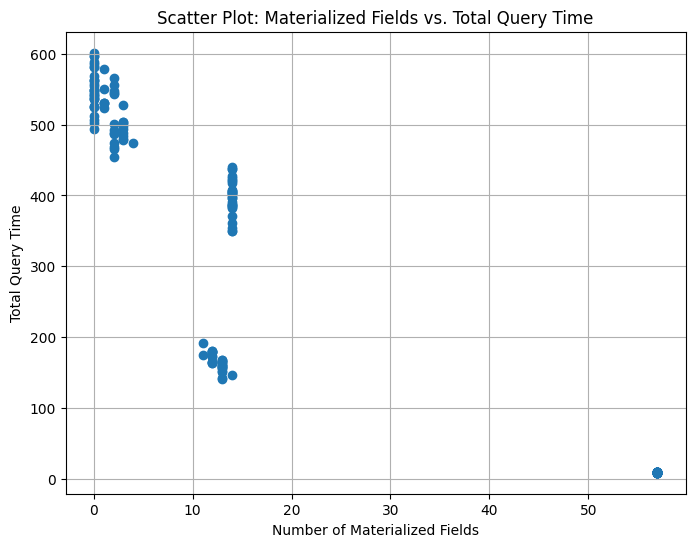

In [54]:
# Create the scatter plot: x-axis = number of materialized fields, y-axis = time taken to materialize
subset = meta_results[meta_results["Total query time"] > 0]
plt.figure(figsize=(8, 6))
plt.scatter(subset["num_materialized_fields"], subset["Total query time"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Total Query Time")
plt.title("Scatter Plot: Materialized Fields vs. Total Query Time")
plt.grid(True)
plt.show()

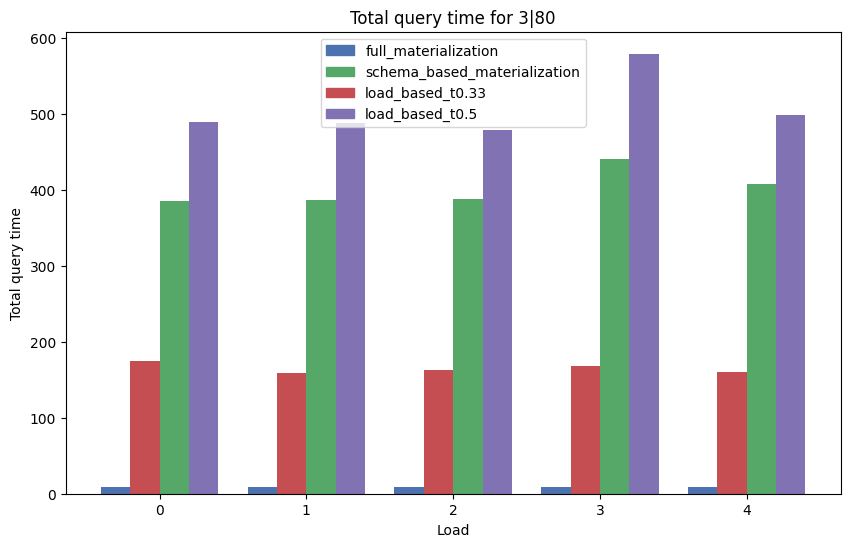

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches


# Filter for Query proportion = 3 and Majority proportion = 80
subset = meta_results[(meta_results["Query proportion"] == 3) & (meta_results["Majority proportion"] == 80)]

# Define the tests to include
tests_to_include = [
    "full_materialization",
    "schema_based_materialization",
    "load_based_t0.33",
    "load_based_t0.5"
]

# Further filter for the desired tests
subset = subset[subset["Test"].isin(tests_to_include)]

# Pivot the DataFrame so that each Load is an index and each Test is a column with "Time taken" as values
pivot_df = subset.pivot(index="Load", columns="Test", values="Total query time").sort_index()

# Define a modern matte color palette for each test
colors = {
    "full_materialization": "#4C72B0",          # muted blue
    "schema_based_materialization": "#55A868",  # muted green
    "load_based_t0.33": "#C44E52",               # muted red
    "load_based_t0.5": "#8172B3"                 # muted purple
}

fig, ax = plt.subplots(figsize=(10, 6))
loads = pivot_df.index.values  # expected loads: 0, 1, 2, 3, 4
x = np.arange(len(loads))        # group positions
width = 0.2                    # width of each bar

# Loop over each load group
for i, load in enumerate(loads):
    # Extract the row for the load group and sort by "Time taken" (ascending)
    group = pivot_df.loc[load]
    sorted_group = group.sort_values()  # sorts tests by time taken
    # Plot each bar in sorted order (left to right)
    for j, test in enumerate(sorted_group.index):
        ax.bar(x[i] + j * width, sorted_group[test], width, color=colors[test])

# Set x-ticks in the center of each group
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(loads)
ax.set_xlabel("Load")
ax.set_ylabel("Total query time")
ax.set_title("Total query time for 3|80")

# Create a custom legend (order as in tests_to_include)
legend_handles = [mpatches.Patch(color=colors[test], label=test) for test in tests_to_include]
ax.legend(handles=legend_handles)

plt.show()


/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_24462/824187846.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["combination"] = subset["Query proportion"].astype(str) + "/" + subset["Majority proportion"].astype(str)


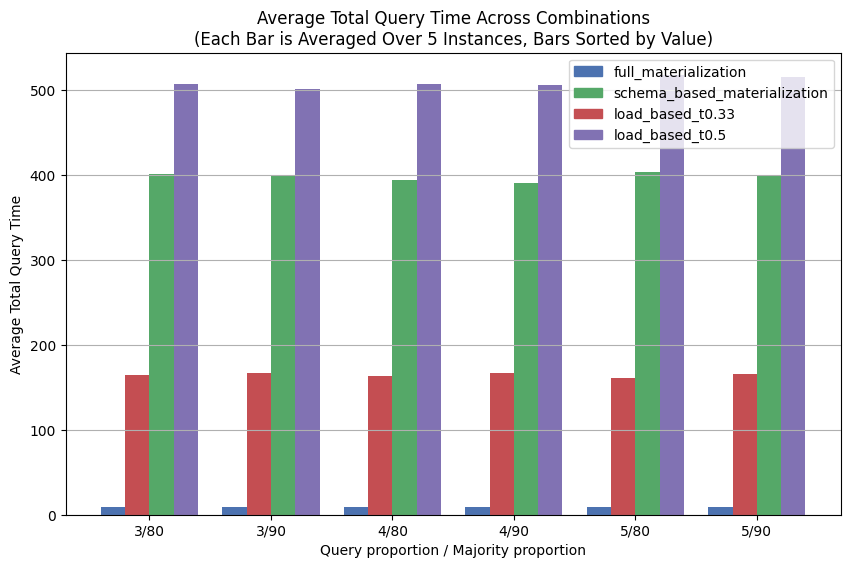

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches


# Filter for the six combinations: 3/80, 3/90, 4/80, 4/90, 5/80, 5/90
subset = meta_results[
    meta_results["Test"].isin(tests_to_include)
]

# Create a new column representing the combination as "Query proportion/Majority proportion"
subset["combination"] = subset["Query proportion"].astype(str) + "/" + subset["Majority proportion"].astype(str)

# Group by combination and Test, averaging the "Total query time" (averaged over 5 instances)
grouped = subset.groupby(["combination", "Test"])["Total query time"].mean().reset_index()

# Pivot the DataFrame so that each combination is an index and each Test is a column
pivot_df = grouped.pivot(index="combination", columns="Test", values="Total query time").sort_index()

# Define a modern matte color palette for each test
colors = {
    "full_materialization": "#4C72B0",          # muted blue
    "schema_based_materialization": "#55A868",  # muted green
    "load_based_t0.33": "#C44E52",              # muted red
    "load_based_t0.5": "#8172B3"                # muted purple
}

fig, ax = plt.subplots(figsize=(10, 6))
combinations_sorted = pivot_df.index.values  # These are our x-axis groups
x = np.arange(len(combinations_sorted))
width = 0.2  # width of each bar

# Loop over each combination group
for i, comb in enumerate(combinations_sorted):
    # Extract the row for the current combination and drop any missing values
    group = pivot_df.loc[comb].dropna()
    # Sort tests by average total query time (ascending)
    sorted_group = group.sort_values()
    # Plot each bar in the sorted order for this combination
    for j, test in enumerate(sorted_group.index):
        ax.bar(x[i] + j * width, sorted_group[test], width, color=colors[test])

# Set x-ticks in the center of each group
ax.set_xticks(x + width * (len(tests_to_include) - 1) / 2)
ax.set_xticklabels(combinations_sorted)
ax.set_xlabel("Query proportion / Majority proportion")
ax.set_ylabel("Average Total Query Time")
ax.set_title("Average Total Query Time Across Combinations\n(Each Bar is Averaged Over 5 Instances, Bars Sorted by Value)")
ax.grid(True, axis='y')

# Create a custom legend (the order is as defined in tests_to_include)
legend_handles = [mpatches.Patch(color=colors[test], label=test) for test in tests_to_include]
ax.legend(handles=legend_handles)

plt.show()
